# CatGAN

## Install and Import Dependencies

In [1]:
download = False
if download:
    !git clone https://github.com/DennisRotondi/visiope_project
    !cd visiope_project
    !pip3 install -r requirements.txt

import os
# import cv2
import random
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import PIL
from PIL import Image,ImageOps
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import dataclasses
from dataclasses import dataclass
from dataclasses import asdict
from pprint import pprint
from collections import OrderedDict
from typing import Sequence, List, Dict, Tuple, Optional, Any, Set, Union, Callable, Mapping

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)

Global seed set to 0


## Dataset Handling

In [2]:
class CatDataset(Dataset):
    
    def __init__(self, 
                 folder, 
                 transform = None
        ):
        
        super().__init__()
        self.folder = Path(folder)
        assert(self.folder.is_dir())
        self.files = list(sorted(self.folder.rglob('*.jpg')))
        assert(self.files)
        self.files_num = len(self.files)
        self.transform = transform


    def __len__(self):
        return self.files_num

    def pil_loader(self,file):
        with file.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        file = self.files[index % self.files_num]
        image = self.pil_loader(file)

        if self.transform is not None:
            image = self.transform(image)
        
        return {
            'file': image,
            'path': str(file)
        }
        
def plot_cats(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Cats images'):
    plt.figure(figsize = (16, 16))
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

visualize some cats from the dataset

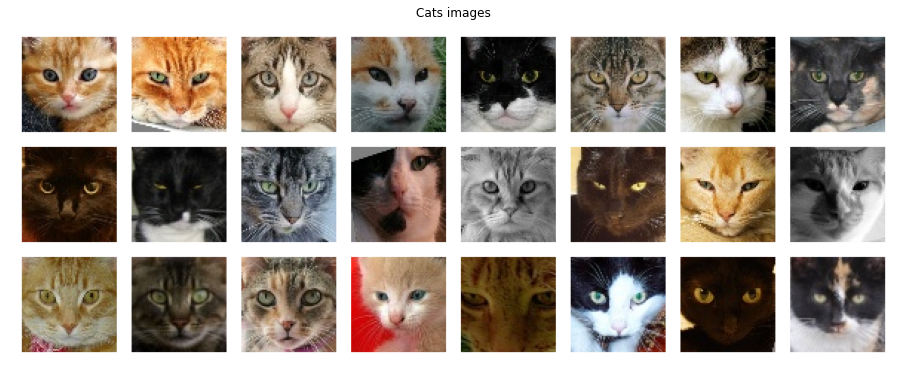

In [3]:
path = "./cats"

catsData = DataLoader(
    CatDataset(
        path,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=24,
    shuffle=True,
)
batch = iter(catsData).next()
plot_cats(batch["file"], images_per_row=8, title="Cats images")

## GAN Model

### Hyperparameters

In [4]:
@dataclass
class Hparams:
    n_epochs: int = 200  # number of epochs of training
    img_height: int = 64  # size of image height # default 256x256
    img_width: int = 64  # size of image width
    batch_size: int = 128  # size of the batches
    lrg: float = 3e-4  # optimizer: learning rate for generator
    lrd: float = 3e-4  # optimizer: learning rate for discriminator
    wdg: float = 1e-4  # weight_decay for generator
    wdd: float = 1e-4  # wd for discriminator
    channels: int = 3  # number of image channels
    n_residual_blocks: int = 6  # number of residual blocks in generator
    n_cpu: int = 8  # number of cpu threads to use for the dataloaders
    latent_dim: int = 100
hparams = Hparams()
pprint(asdict(hparams))

{'batch_size': 128,
 'channels': 3,
 'img_height': 64,
 'img_width': 64,
 'latent_dim': 100,
 'lrd': 0.0003,
 'lrg': 0.0003,
 'n_cpu': 8,
 'n_epochs': 200,
 'n_residual_blocks': 6,
 'wdd': 0.0001,
 'wdg': 0.0001}


In [5]:
class Generator(nn.Module):
    def __init__(self,hparams):
        super(Generator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams['channels'], hparams['img_height'], hparams['img_width'])
        
        #built according to this benchmark: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
        def gan_block(in_features, out_features, normalize=True):
            layer = [nn.Linear(in_features, out_features)]
            layer.append(nn.PReLU())
            if normalize:
                layer.append(nn.BatchNorm1d(out_features))
            layer.append(nn.Dropout(0.2))
            return layer

        self.model = nn.Sequential(
            *gan_block(self.hparams['latent_dim'], 128, normalize=False),
            *gan_block(128, 256),
            *gan_block(256, 512),
            *gan_block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self,hparams):
        super(Discriminator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams['channels'], hparams['img_height'], hparams['img_width'])
        
        #linear layers to not make discriminator much better than generator (using convolutions it would be really easy to classify bad examples)
        self.layers = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 2048),
            nn.PReLU(),
            nn.Linear(2048, 1024),
            nn.PReLU(),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_linear = img.view(img.size(0), -1)
        img_class = self.layers(img_linear)
        return img_class

class CatGAN(pl.LightningModule):
    def __init__(
        self,
        hparams,
        train_folder):
        super().__init__()
        self.save_hyperparameters(asdict(hparams) if not isinstance(hparams, Mapping) else hparams) #Save arguments to ``hparams`` attribute.
        self.train_folder = train_folder
        self.generator = Generator(self.hparams)
        self.discriminator = Discriminator(self.hparams)
        self.validation_z = torch.randn(8, self.hparams['latent_dim'])

        # Image Normalizations
        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )
    def forward(self, x):
        return self.generator(x)

    def train_dataloader(self):
        train_loader = DataLoader(
            CatDataset(
                self.train_folder, transform=self.image_transforms
            ),
            batch_size=self.hparams['batch_size'],
            shuffle=True,
            num_workers=self.hparams['n_cpu']
        )
        return train_loader

    def configure_optimizers(self):
        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.hparams['lrg'], weight_decay=self.hparams['wdg'])
        optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self.hparams['lrd'], weight_decay=self.hparams['wdd'])
        return [optimizer_G,optimizer_D],[]

    def adversarial_loss(self, y_est, y):
        return F.binary_cross_entropy(y_est, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs = batch['file']

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams['latent_dim'])
        z = z.type_as(imgs) #Returns the z tensor cast to the type of the given tensor.

        # train generator
        if optimizer_idx == 0:
            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            sample_imgs = self.generated_imgs[:8]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image("generated_images", grid, 0)

            # to fool the discriminator we have to set all the generator images as true
            valid = torch.ones(imgs.size(0), 1).type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid) #we perform the forward step here
            log = {"g_loss": g_loss}
            output = OrderedDict({"loss": g_loss, "progress_bar": log, "log": log})

        # train discriminator
        if optimizer_idx == 1:
            #we train on real images to be discriminated as real
            valid = torch.ones(imgs.size(0), 1).type_as(imgs)
            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
            #we train of fake images to be discriminated as fake
            fake = torch.zeros(imgs.size(0), 1).type_as(imgs)
            fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)
            # discriminator loss is half the sum of these
            d_loss = (real_loss + fake_loss) / 2
            log = {"d_loss": d_loss}
            output = OrderedDict({"loss": d_loss, "progress_bar": log, "log": log})
        return output

    def on_train_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

In [6]:
catgan = CatGAN(hparams,path)
trainer = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20)
trainer.fit(catgan)

/home/dennis/Applications/anaconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dennis/Applications/anaconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_dep

Epoch 19:   0%|          | 0/124 [00:00<?, ?it/s, loss=2.11, v_num=9]           

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/